In [11]:
import tensorflow as tf
import pandas as pd
import numpy as np



from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
from tensorflow.keras.utils import plot_model

In [5]:
MODEL_SAVE_PATH = './model_weights'
RANDOM_SEED = 15

In [4]:
model_whole_load = tf.keras.models.load_model(MODEL_SAVE_PATH+'/model_multi_target_whole.h5')

TypeError: __init__() got an unexpected keyword argument 'reduction'

In [6]:
tf.random.set_seed(RANDOM_SEED)

inputs = tf.keras.Input(shape = (80,2))
x = LSTM(80, input_shape = (80,2), return_sequences= True )(inputs)
x = layers.Bidirectional(LSTM(80, return_sequences = True))(x)
x = layers.Bidirectional(LSTM(80))(x)


y = Dense(50, activation= 'relu')(x)
z = Dense(50, activation = 'relu')(x)
price_output = Dense(10, name = 'price_output')(y)
volume_output = Dense(10, name = 'volume_output')(z)

model_reweight = Model(inputs = inputs, outputs = [price_output, volume_output])

In [7]:
model_reweight.load_weights(MODEL_SAVE_PATH+'/model_multi_target.h5')

In [10]:
model_reweight.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 2)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 80, 80)       26560       ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, 80, 160)      103040      ['lstm[0][0]']                   
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 160)         154240      ['bidirectional[0][0]']          
 )                                                                                            

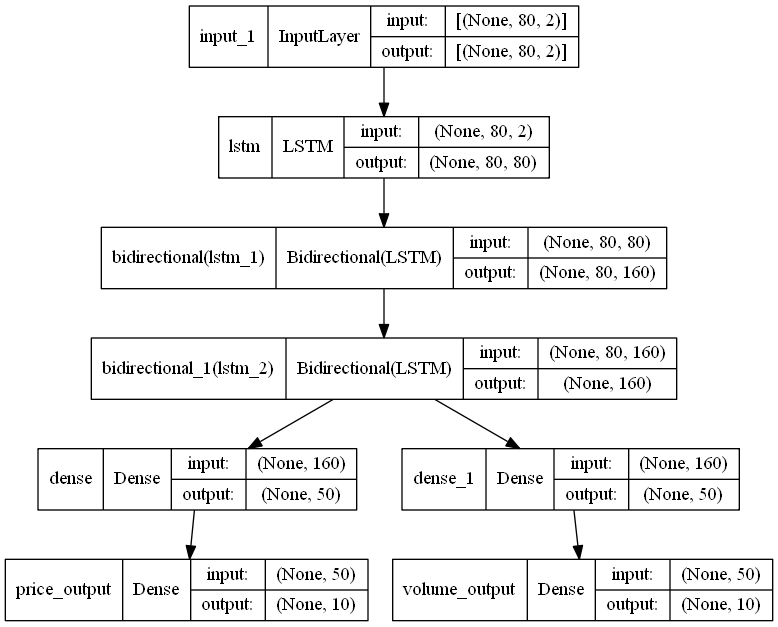

In [13]:
plot_model(model_reweight, show_layer_names= True, show_shapes=True)

# Importing Data

# Dataset creation